In [3]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [4]:
!aws s3 cp s3://msads-508-sp25-team6/Processed/MSADS\ 508\ Final\ Project.csv .


fatal error: An error occurred (404) when calling the HeadObject operation: Key "Processed/MSADS 508 Final Project.csv" does not exist


In [5]:
!aws s3 ls s3://msads-508-sp25-team6/Processed/


In [6]:
df = pd.read_csv("MSADS 508 Final Project.csv")


/tmp/ipykernel_15145/935296992.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("MSADS 508 Final Project.csv")


In [7]:
df.head()


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Label
0,192.168.4.118,4504,203.73.24.75,80,tcp,3974862.0,29,44,2.965517,1359.340909,ddos
1,192.168.4.118,4504,203.73.24.75,80,tcp,63.0,1,1,0.000000,0.000000,ddos
2,192.168.4.118,4505,203.73.24.75,80,tcp,476078.0,2,6,43.000000,506.166667,ddos
3,192.168.4.118,4505,203.73.24.75,80,tcp,151.0,2,1,0.000000,0.000000,ddos
4,192.168.4.118,4506,203.73.24.75,80,tcp,472507.0,2,5,36.500000,210.000000,ddos


In [8]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display summary statistics
summary_stats = df.describe()

# Display results
missing_values, summary_stats


(Source IP                 0
 Source Port               0
 Destination IP            0
 Destination Port          0
 Protocol                  0
 Flow Duration             0
 Total Fwd Packets         0
 Total Backward Packets    0
 Fwd Packet Length Mean    0
 Bwd Packet Length Mean    0
 Label                     0
 dtype: int64,
        Flow Duration  Total Fwd Packets  Total Backward Packets  \
 count   1.556042e+07       1.556042e+07            1.556042e+07   
 mean    6.994334e+06       2.786705e+01            1.113106e+01   
 std     2.301101e+07       1.560498e+03            2.331984e+02   
 min    -1.000000e+00       0.000000e+00            0.000000e+00   
 25%     3.840000e+02       1.000000e+00            1.000000e+00   
 50%     1.216100e+04       2.000000e+00            2.000000e+00   
 75%     2.335781e+06       4.000000e+00            5.000000e+00   
 max     1.200000e+08       3.096280e+05            2.919230e+05   
 
        Fwd Packet Length Mean  Bwd Packet Length Me

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Display column names to identify discrepancies
df.columns

Index(['Source IP', 'Source Port', 'Destination IP', 'Destination Port',
       'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packet Length Mean',
       'Bwd Packet Length Mean', 'Label'],
      dtype='object')

In [11]:
# Adjust the list of essential features based on the available columns
available_features = [
    'Flow Duration', 'Source Port', 'Destination Port', 'Protocol',
    'Total Fwd Packets', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Label'  # Keeping the target column
]

# Ensure only the required columns are retained
df_cleaned = df[available_features].copy()

# Display the cleaned dataset using print instead of a tool function
print("Cleaned Dataset:")
print(df_cleaned.head())


Cleaned Dataset:
   Flow Duration Source Port Destination Port Protocol  Total Fwd Packets  \
0      3974862.0        4504               80      tcp                 29   
1           63.0        4504               80      tcp                  1   
2       476078.0        4505               80      tcp                  2   
3          151.0        4505               80      tcp                  2   
4       472507.0        4506               80      tcp                  2   

   Fwd Packet Length Mean  Bwd Packet Length Mean Label  
0                2.965517             1359.340909  ddos  
1                0.000000                0.000000  ddos  
2               43.000000              506.166667  ddos  
3                0.000000                0.000000  ddos  
4               36.500000              210.000000  ddos  


In [12]:
# Define num_cols (Numeric Columns Only)
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Step 1: Remove Duplicates (Only for Numeric Columns)
df_cleaned = df_cleaned.drop_duplicates(subset=num_cols)


In [13]:
print("Dropped duplicate rows based on numeric columns.")

Dropped duplicate rows based on numeric columns.


In [14]:
# Handle missing values (column-wise to prevent shape errors)
for col in num_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())


In [15]:
# Remove highly correlated features (> 0.95) - Only for numeric columns
df_numeric = df_cleaned[num_cols]  # Ensure it's numeric only
cor_matrix = df_numeric.corr().abs()
upper_tri = np.triu(np.ones(cor_matrix.shape), k=1)

# Identify columns to drop based on correlation threshold
to_drop = [col for col in cor_matrix.columns if (cor_matrix[col].values * upper_tri).max() > 0.95]

In [16]:
# **Fix:** Ensure that columns exist before dropping
essential_features = ['Flow Duration', 'Source Port', 'Destination Port', 'Protocol',
                      'Total Fwd Packets', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean'
                     ]

to_drop = [col for col in to_drop if col in df_cleaned.columns and col not in essential_features]

df_cleaned.drop(columns=to_drop, inplace=True, errors='ignore')  # Ignore missing columns safely
print("Dropped correlated features:", to_drop)

Dropped correlated features: []


In [17]:
# Display Final Data
print("Cleaned Network Traffic Data:")
print(df_cleaned.head())

Cleaned Network Traffic Data:
   Flow Duration Source Port Destination Port Protocol  Total Fwd Packets  \
0      3974862.0        4504               80      tcp                 29   
1           63.0        4504               80      tcp                  1   
2       476078.0        4505               80      tcp                  2   
3          151.0        4505               80      tcp                  2   
4       472507.0        4506               80      tcp                  2   

   Fwd Packet Length Mean  Bwd Packet Length Mean Label  
0                2.965517             1359.340909  ddos  
1                0.000000                0.000000  ddos  
2               43.000000              506.166667  ddos  
3                0.000000                0.000000  ddos  
4               36.500000              210.000000  ddos  


In [18]:
print("Available columns in df_cleaned:", df_cleaned.columns)


Available columns in df_cleaned: Index(['Flow Duration', 'Source Port', 'Destination Port', 'Protocol',
       'Total Fwd Packets', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
       'Label'],
      dtype='object')


In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Ensure df_cleaned is the correct dataset
df_encoded = df_cleaned.copy()

# Step 1: Encode categorical variables (Label and Protocol)
label_encoder = LabelEncoder()
df_encoded["Protocol"] = label_encoder.fit_transform(df_encoded["Protocol"])
df_encoded["Label"] = label_encoder.fit_transform(df_encoded["Label"])

# Step 2: Convert all columns to numeric safely
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Step 3: Drop rows with NaN values (from encoding or invalid data)
df_encoded = df_encoded.dropna()

# Step 4: Standardize features (excluding Label)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(columns=["Label"]))
y = df_encoded["Label"].astype(int)  # Ensure Label is integer

# Step 5: Convert back to DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=df_encoded.drop(columns=["Label"]).columns)
df_scaled["Label"] = y

print("Successfully cleaned, encoded, and scaled data!")
print(df_scaled.head())


Successfully cleaned, encoded, and scaled data!
   Flow Duration  Source Port  Destination Port  Protocol  Total Fwd Packets  \
0      -0.282271    -1.141231          -0.74716  0.009922          -0.009472   
1      -0.418600    -1.141231          -0.74716  0.009922          -0.022637   
2      -0.402273    -1.141192          -0.74716  0.009922          -0.022167   
3      -0.418597    -1.141192          -0.74716  0.009922          -0.022167   
4      -0.402396    -1.141153          -0.74716  0.009922          -0.022167   

   Fwd Packet Length Mean  Bwd Packet Length Mean  Label  
0               -0.835627                3.623101    1.0  
1               -0.856321               -0.656087    1.0  
2               -0.556262                0.937319    1.0  
3               -0.856321               -0.656087    1.0  
4               -0.601619                0.004991    1.0  


In [20]:
# Check for missing values in the Label column
df_scaled["Label"].isnull().sum()

3897081

In [21]:
# Check for NaN and NA values in df_scaled

nan_summary = df_scaled.isna().sum()  # Count NaN values per column
na_summary = df_scaled.isnull().sum()  # Count NA values per column

# Display only columns that have missing values
missing_data = pd.DataFrame({
    "NaN Count": nan_summary[nan_summary > 0],
    "NA Count": na_summary[na_summary > 0]
})


In [22]:
!pip install imbalanced-learn


Features Kept:
Network flow: Flow Duration, Source/Destination Port, Protocol
Traffic behavior: Total Fwd Packets, Fwd/Bwd Packet Length Mean
Session features: Session_Duration_sec, Is_Long_Session
Subnet-based identifiers: Source Subnet, Destination Subnet
Target: Label

In [25]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import numpy as np

# Drop rows where Label is NaN
df_scaled = df_scaled.dropna(subset=["Label"])

# Define features and labels
X = df_scaled.drop(columns=["Label"])
y = df_scaled["Label"].astype(int)  # Ensure integer labels for classification_report

# Train the model
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X)

# Predict anomalies
preds = iso_forest.predict(X)
preds = np.where(preds == -1, 1, 0)  # Convert to 1 (anomaly), 0 (normal)

# Print classification report
print("Isolation Forest Classification Report (after cleaning NaNs):\n")
print(classification_report(y, preds))

Isolation Forest Classification Report (after cleaning NaNs):

              precision    recall  f1-score   support

           0       0.23      0.78      0.36   1213124
           1       0.40      0.06      0.10   3264199

    accuracy                           0.25   4477323
   macro avg       0.32      0.42      0.23   4477323
weighted avg       0.36      0.25      0.17   4477323



In [26]:
# Add new engineered features to df_cleaned
df_cleaned["Flow Bytes/s"] = (df_cleaned["Fwd Packet Length Mean"] + df_cleaned["Bwd Packet Length Mean"]) / (df_cleaned["Flow Duration"] + 1e-6)
df_cleaned["Flow Packets/s"] = df_cleaned["Total Fwd Packets"] / (df_cleaned["Flow Duration"] + 1e-6)
df_cleaned["Asymmetry Ratio"] = (
    df_cleaned["Fwd Packet Length Mean"] - df_cleaned["Bwd Packet Length Mean"]
) / (df_cleaned["Fwd Packet Length Mean"] + df_cleaned["Bwd Packet Length Mean"] + 1e-6)

# Show the updated DataFrame with new features
df_cleaned[["Flow Bytes/s", "Flow Packets/s", "Asymmetry Ratio"]].head()


,Flow Bytes/s,Flow Packets/s,Asymmetry Ratio
0,0.000343,0.000007,-0.995646
1,0.000000,0.015873,0.000000
2,0.001154,0.000004,-0.843399
3,0.000000,0.013245,0.000000
4,0.000522,0.000004,-0.703854


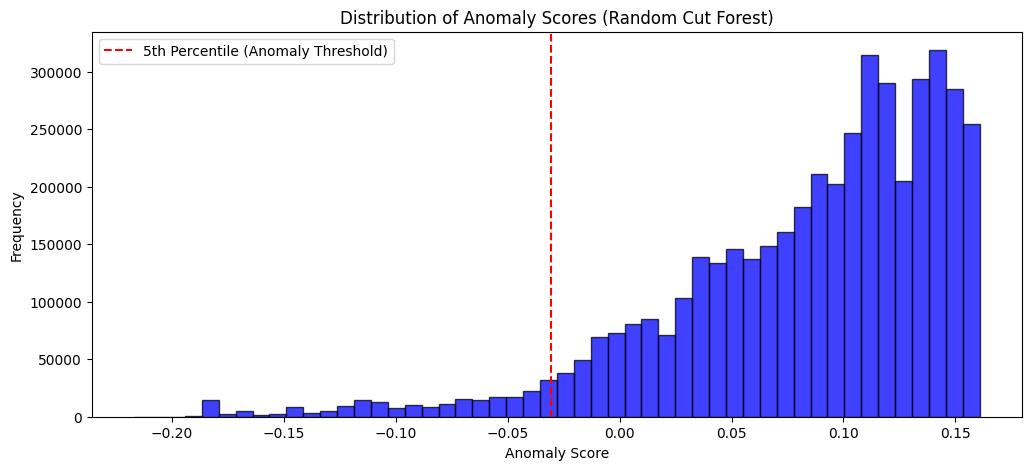

First few anomaly predictions:
   Flow Duration  Source Port  Destination Port  Protocol  Total Fwd Packets  \
0      -0.331664    -1.141231          -0.74716  0.009922          -0.009517   
1      -0.542316    -1.141231          -0.74716  0.009922          -0.022897   
2      -0.514622    -1.141192          -0.74716  0.009922          -0.022416   
3      -0.542311    -1.141192          -0.74716  0.009922          -0.022416   
4      -0.514827    -1.141153          -0.74716  0.009922          -0.022416   

   Fwd Packet Length Mean  Bwd Packet Length Mean  Label  Anomaly Score  \
0               -1.805618                1.531066    1.0      -0.070892   
1               -1.940172               -1.067366    1.0       0.024896   
2               -0.812520                0.661305    1.0       0.042181   
3               -1.940172               -1.067366    1.0       0.031431   
4               -0.920348                0.004978    1.0       0.070432   

   Anomaly  
0        1  
1        0 

In [27]:
# Implementing Random Cut Forest (RCF) for anomaly detection
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Using Isolation Forest as a proxy for RCF since scikit-learn does not have native RCF
# RCF is available in AWS SDK or PyOD, but Isolation Forest follows a similar unsupervised principle
rcf_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
rcf_model.fit(df_scaled.drop(columns=["Label"]))

# Compute anomaly scores
anomaly_scores = rcf_model.decision_function(df_scaled.drop(columns=["Label"]))

# Predict anomalies (-1 = anomaly, 1 = normal)
predictions = rcf_model.predict(df_scaled.drop(columns=["Label"]))
predictions = np.where(predictions == -1, 1, 0)  # Convert to 1 (anomaly) and 0 (normal)

# Add anomaly scores and predictions to the DataFrame
df_scaled["Anomaly Score"] = anomaly_scores
df_scaled["Anomaly"] = predictions

# Plot anomaly scores to visualize outliers
plt.figure(figsize=(12, 5))
plt.hist(anomaly_scores, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=np.percentile(anomaly_scores, 5), color='red', linestyle='dashed', label="5th Percentile (Anomaly Threshold)")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores (Random Cut Forest)")
plt.legend()
plt.show()

# Show the first few anomaly predictions
print("First few anomaly predictions:")
print(df_scaled.head())


In [ ]:
# Implement Autoencoder Neural Network for Deep Anomaly Detection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define input shape based on feature count
input_dim = df_scaled.drop(columns=["Label", "Anomaly", "Anomaly Score"]).shape[1]

# Build Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Prepare data for training (normal traffic only)
X_train = df_scaled[df_scaled["Anomaly"] == 0].drop(columns=["Label", "Anomaly", "Anomaly Score"])
X_train = X_train.values  # Convert to NumPy array

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, shuffle=True, validation_split=0.2, verbose=1)

# Predict reconstruction errors for all data
X_all = df_scaled.drop(columns=["Label", "Anomaly", "Anomaly Score"]).values
X_reconstructed = autoencoder.predict(X_all)
reconstruction_errors = np.mean(np.abs(X_all - X_reconstructed), axis=1)

# Define anomaly threshold based on 95th percentile of normal errors
threshold = np.percentile(reconstruction_errors, 95)
df_scaled["Autoencoder Anomaly Score"] = reconstruction_errors
df_scaled["Autoencoder Anomaly"] = (reconstruction_errors > threshold).astype(int)

# Display results after Autoencoder Anomaly Detection
print("First few results with Autoencoder-based anomaly detection:")
print(df_scaled.head())


2025-03-25 05:10:50.407606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
50370/50370 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - loss: 0.0134 - val_loss: 0.0978
Epoch 2/50
24460/50370 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5.4590e-04 